### NOAA ETSS Beautiful Soup Web Scraper
#### The first step utilizes the requests library to issue an HTTP get request.
#### This will retrieve the html data and store it in python for use.

In [48]:
import requests
from bs4 import BeautifulSoup

URL = "https://slosh.nws.noaa.gov/etsurge/index.php?page=stn&region=gm&datum=msl&list=&map=0-48&type=text&stn=flpete"
page = requests.get(URL)

print(page.text)
soup = BeautifulSoup(page.content, "html.parser") 

<!DOCTYPE html>
<html lang="en" xmlns="https://www.w3.org/1999/xhtml">
<head>
  <SCRIPT LANGUAGE="JavaScript"><!-- Hide script
// End hide -->
</SCRIPT>
  <title>ETSS stn</title>
  <meta name="DC.title" content="Extra-Tropical Storm Surge">
  <meta name="DC.description" content="Extra-Tropical Storm Surge landing page">
  <meta name="DC.creator" content="NWS/Meteorological Development Lab">
  <meta name="DC.language" scheme="DCTERMS.RFC1766" content="EN-US">
  <meta name="rating" content="general">
  <meta name="resource-type" content="document">
  <meta name="distribution" content="global">
  <meta http-equiv="Window-target" content="_top">
  <meta charset="iso-8859-1">
  <base target="_self">

  <link rel="stylesheet" type="text/css" href="ss/ssMain.css">
  <meta name="Keywords" content="etsurge, extra tropical storm surge, extra-tropical storm surge, extratropcial storm surge, storm surge, SLOSH">

  <link rel="stylesheet" type="text/css" href="etsurge2.0main.css"/>
  <link rel="sty

In [49]:
# Scrape the wrapper2 id to help reduce the amount of data.
#results = soup.find(id="wrapper2")
#print(results.prettify)

In [50]:
# Extract the content between the <pre> tags
pre_content = soup.find('pre').get_text()

# Output the NOAA etss data table 
print(pre_content)

#Saint Petersburg, FL : 10/25/2024 01:20:19 GMT (units in feet MSL)
#Date(GMT), Surge,   Tide,    Obs,   Fcst,   Anom, Comment
#------------------------------------------------------------
10/23 06Z,   0.30,   0.99,   1.47,  99.90,   0.18,
10/23 07Z,   0.30,   1.19,   1.56,  99.90,   0.07,
10/23 08Z,   0.20,   1.35,   1.65,  99.90,   0.10,
10/23 09Z,   0.20,   1.43,   1.73,  99.90,   0.10,
10/23 10Z,   0.20,   1.39,   1.75,  99.90,   0.16,  (max)
10/23 11Z,   0.30,   1.23,   1.67,  99.90,   0.14,
10/23 12Z,   0.30,   0.97,   1.44,  99.90,   0.17,
10/23 13Z,   0.30,   0.62,   1.10,  99.90,   0.18,
10/23 14Z,   0.30,   0.22,   0.63,  99.90,   0.11,
10/23 15Z,   0.30,  -0.20,   0.14,  99.90,   0.04,
10/23 16Z,   0.30,  -0.58,  -0.29,  99.90,  -0.01,
10/23 17Z,   0.30,  -0.87,  -0.62,  99.90,  -0.05,
10/23 18Z,   0.40,  -1.03,  -0.76,  99.90,  -0.13,  (min)
10/23 19Z,   0.40,  -1.04,  -0.70,  99.90,  -0.06,
10/23 20Z,   0.40,  -0.91,  -0.48,  99.90,   0.03,
10/23 21Z,   0.40,  -0.70,  -0.2

### Now let's create a pandas dataframe from the data. This will allow us to calculate and plot parameters
#### All values of 99.90 have been replaced with NaN. NOAA's dataset should be examined to understand 99.90 values.


In [52]:
import pandas as pd
import numpy as np

# Split the NOAA pre_content from the ETSS website
lines = pre_content.splitlines()

# Filter out comments and empty lines (lines start with '#')
data_lines = [line for line in lines if not line.startswith('#') and line.strip()]

# Split each valid line by commas and remove extra spaces
data = [line.split(',') for line in data_lines]

# Create Pandas DataFrame from the extracted data
columns = ['Date(GMT)', 'Surge', 'Tide', 'Obs', 'Fcst', 'Anom', 'Comment']
df = pd.DataFrame(data, columns=columns)

# Apply strip to all string cells in the DataFrame
df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# Convert numeric columns to appropriate data types
df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']] = df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']].astype(float)

# Replace any value equal to 99.90 with NaN
df.replace(99.90, np.nan, inplace=True)

# Print df
print(df)

     Date(GMT)  Surge  Tide   Obs  Fcst  Anom Comment
0    10/23 06Z    0.3  0.99  1.47   NaN  0.18        
1    10/23 07Z    0.3  1.19  1.56   NaN  0.07        
2    10/23 08Z    0.2  1.35  1.65   NaN  0.10        
3    10/23 09Z    0.2  1.43  1.73   NaN  0.10        
4    10/23 10Z    0.2  1.39  1.75   NaN  0.16   (max)
..         ...    ...   ...   ...   ...   ...     ...
128  10/28 14Z    0.3  0.38   NaN  0.89  0.21        
129  10/28 15Z    0.3  0.64   NaN  1.14  0.21        
130  10/28 16Z    0.3  0.80   NaN  1.31  0.21   (max)
131  10/28 17Z    0.2  0.83   NaN  1.23  0.21        
132  10/28 18Z    0.2  0.69   NaN  1.10  0.21        

[133 rows x 7 columns]


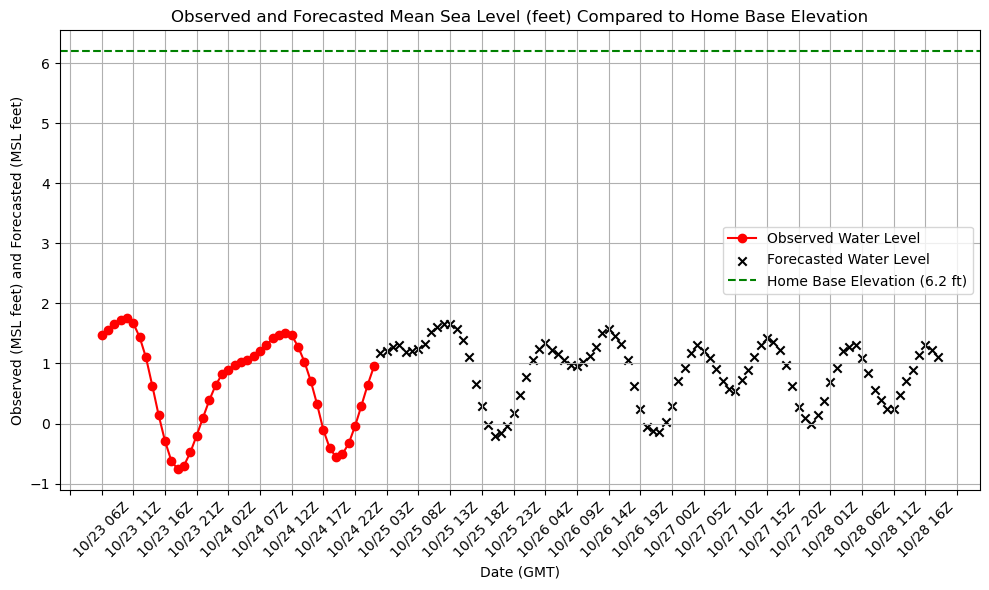

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set the base elevation value
home_base_elev = 6.2

# Step 5: Strip any leading/trailing whitespace from the DataFrame cells
df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

# Step 6: Convert numeric columns to appropriate data types
df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']] = df[['Surge', 'Tide', 'Obs', 'Fcst', 'Anom']].astype(float)

# Step 7: Plot Date(GMT) (x) vs Surge (y)
plt.figure(figsize=(10, 6))

# X values will be 'Date(GMT)' and Y values will be 'Surge'
plt.plot(df['Date(GMT)'], df['Obs'], marker='o', linestyle='-', color='r', label='Observed Water Level')
# Add Fcst values as black 'X' markers
plt.scatter(df['Date(GMT)'], df['Fcst'], color='black', marker='x', label='Forecasted Water Level')
# Add a horizontal line at y = home_base_elev
plt.axhline(y=home_base_elev, color='g', linestyle='--', label=f'Home Base Elevation ({home_base_elev} ft)')

# Formatting the plot
plt.xlabel('Date (GMT)')
plt.ylabel('Observed (MSL feet) and Forecasted (MSL feet)')
plt.title('Observed and Forecasted Mean Sea Level (feet) Compared to Home Base Elevation')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
# Reducing the number of dates/times on the x-axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))  # Limit to 6 x-axis labels

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()
